In [2]:
# --- Step 1: Import Libraries ---

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set plot style
plt.style.use('fivethirtyeight')

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Fetching maximum available hourly data for AAPL (up to 730 days)...


C:\Users\INDIA\AppData\Local\Temp\ipykernel_19864\2488812523.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, period="730d", interval="1h")
[*********************100%***********************]  1 of 1 completed


Data downloaded successfully. Columns found:
MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

Last 5 rows of data:
Price                           Close        High         Low        Open  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Datetime                                                                    
2025-08-08 15:30:00+00:00  228.199997  228.225006  224.309998  224.354996   
2025-08-08 16:30:00+00:00  228.675003  230.889999  227.943604  228.209793   
2025-08-08 17:30:00+00:00  229.289993  230.990005  228.550003  228.669998   
2025-08-08 18:30:00+00:00  228.830002  229.879898  228.509995  229.291595   
2025-08-08 19:30:00+00:00  229.369995  229.690002  228.460007  228.820007   

Price                        Volume  
Ticker                         AAPL  
Datetime                             
202

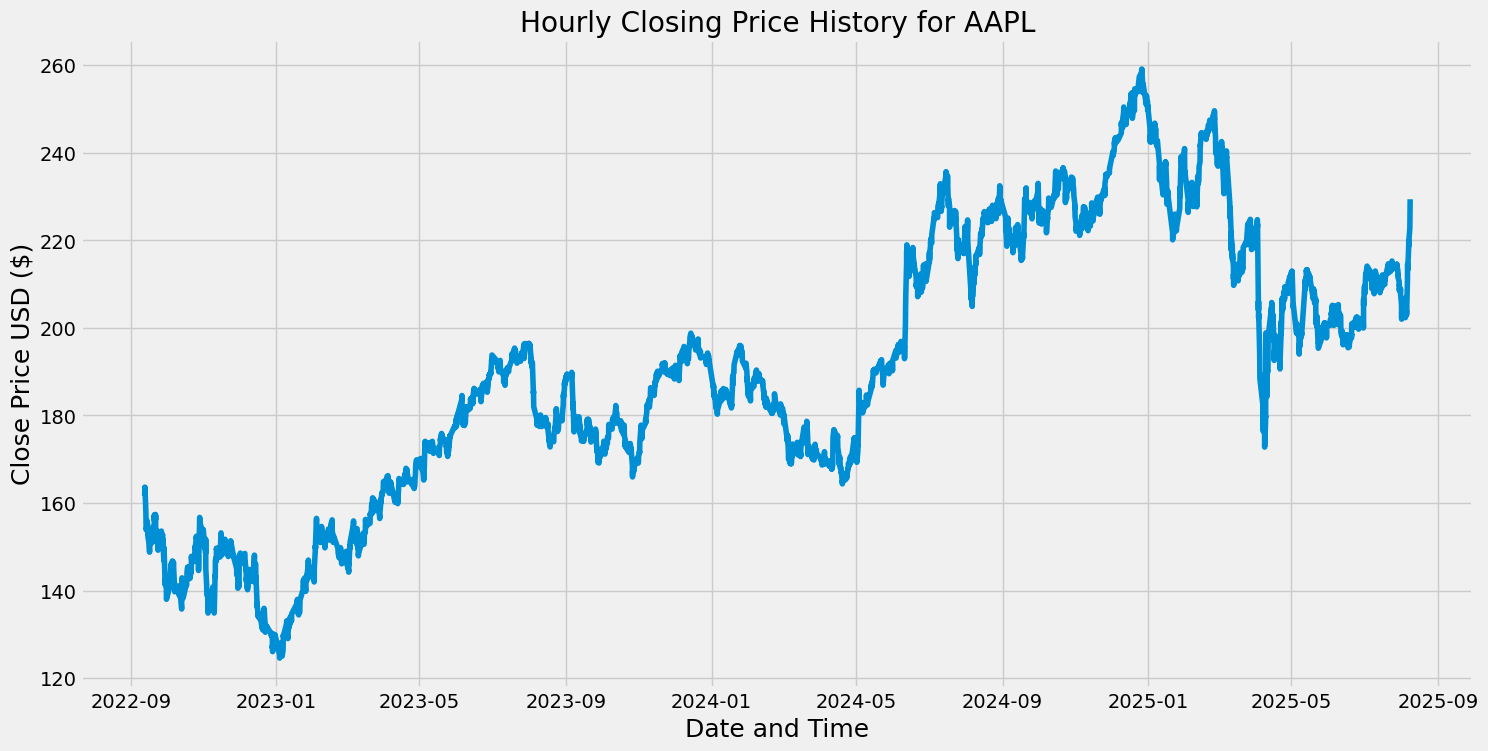

In [5]:
# --- Step 2: Fetch and Verify Hourly Data ---

# Define the ticker
TICKER = 'AAPL'

# For hourly data, yfinance limits the download to 730 days.
print(f"Fetching maximum available hourly data for {TICKER} (up to 730 days)...")
data = yf.download(TICKER, period="730d", interval="1h")

# --- !! IMPORTANT VERIFICATION STEP !! ---
if data.empty:
    print(f"Error: No data downloaded for ticker {TICKER}. It might be an invalid ticker or there's a network issue.")
    # Stop execution or handle the error appropriately in a real script
    # For a notebook, we'll print an error and the subsequent cells will fail as expected.
else:
    print("Data downloaded successfully. Columns found:")
    print(data.columns)
    print("\nLast 5 rows of data:")
    print(data.tail())

# Plot the closing price history (only if data is not empty)
if not data.empty:
    plt.figure(figsize=(16,8))
    plt.title(f'Hourly Closing Price History for {TICKER}')
    plt.plot(data['Close'])
    plt.xlabel('Date and Time', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.show()

In [7]:
# --- Step 3: Preprocess Data ---

# We'll proceed only if the 'data' DataFrame is not empty
if not data.empty and 'Close' in data.columns:
    # Create a new dataframe with only the 'Close' column
    close_data = data.filter(['Close'])
    dataset = close_data.values
    print(dataset)
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_dataset = scaler.fit_transform(dataset)

    # We will use the last 60 hours of data to predict the 61st hour.
    TIME_STEP = 60
    
    print("Data preprocessing complete.")
else:
    print("Skipping preprocessing because no data was loaded in the previous step.")

[]


ValueError: Found array with 0 feature(s) (shape=(5082, 0)) while a minimum of 1 is required by MinMaxScaler.

Fetching maximum available hourly data for AAPL (730d)...


C:\Users\INDIA\AppData\Local\Temp\ipykernel_19864\1173639360.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


Data fetched successfully. Original shape: (5082, 5) -> After dropna: (5082, 5)


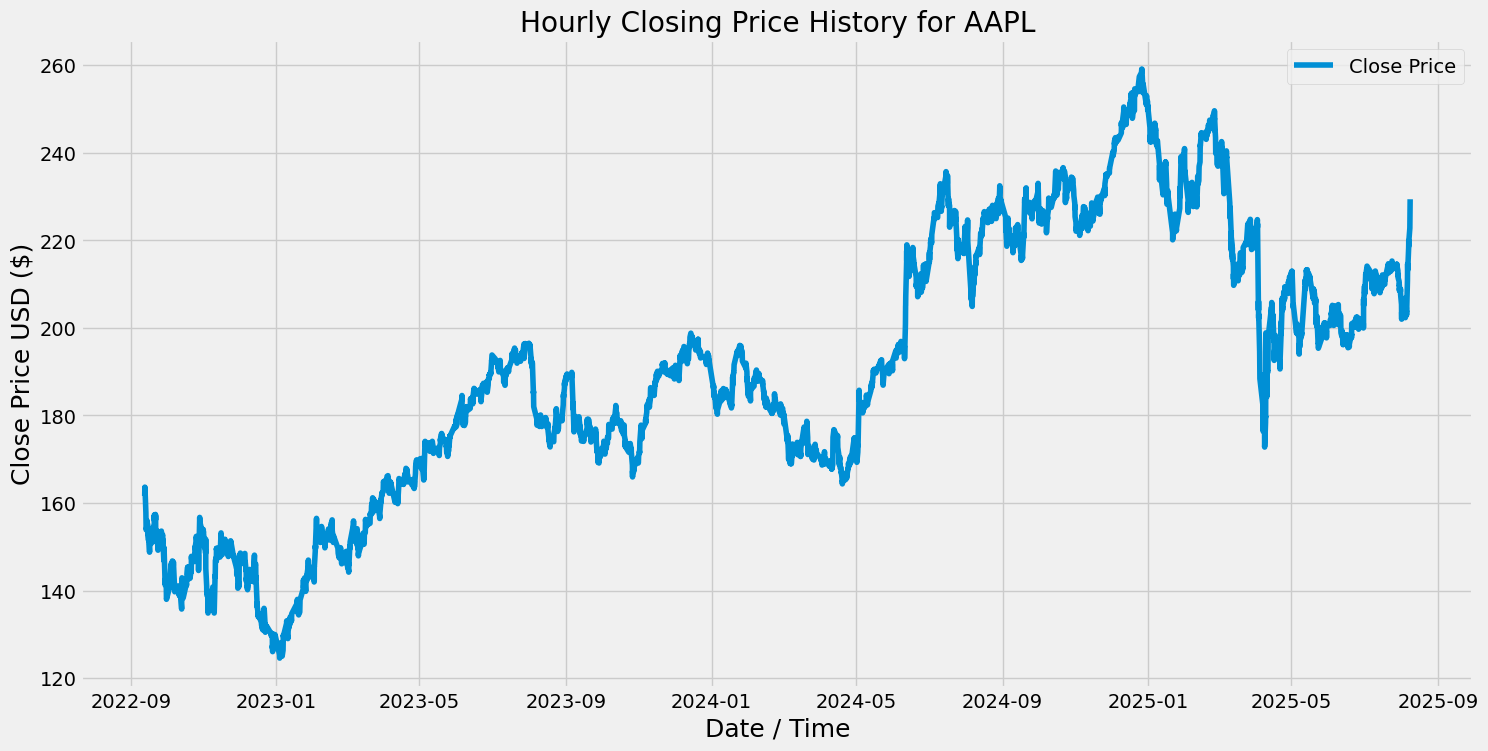

Preprocessing complete. Ready for model building/training.


In [10]:
# --- Combined Cell: Safe Fetch, Verify, and Preprocess Data ---

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Config
TICKER = 'AAPL'
PERIOD = "730d"
INTERVAL = "1h"
TIME_STEP = 60

print(f"Fetching maximum available hourly data for {TICKER} ({PERIOD})...")

def safe_fetch(ticker, period, interval):
    try:
        df = yf.download(ticker, period=period, interval=interval, progress=False)
    except Exception as e:
        raise RuntimeError(f"Download failed for {ticker}: {e}")

    if df.empty:
        raise ValueError(f"No data returned for {ticker} with period={period}, interval={interval}")

    # Drop NaNs and check again
    original_shape = df.shape
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError(f"After dropping NaNs, no usable data remains for {ticker}")

    print(f"Data fetched successfully. Original shape: {original_shape} -> After dropna: {df.shape}")
    return df

try:
    data = safe_fetch(TICKER, PERIOD, INTERVAL)

    if 'Close' not in data.columns:
        raise KeyError(f"'Close' column missing. Columns available: {list(data.columns)}")

    # Plot closing prices
    plt.figure(figsize=(16, 8))
    plt.title(f'Hourly Closing Price History for {TICKER}')
    plt.plot(data['Close'], label='Close Price')
    plt.xlabel('Date / Time', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.legend()
    plt.show()

    # Prepare close price dataset
    close_data = data[['Close']]
    dataset = close_data.values

    # Scale safely
    if dataset.shape[0] < TIME_STEP:
        raise ValueError(f"Not enough data to create sequences (got {dataset.shape[0]} rows, need at least {TIME_STEP})")

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_dataset = scaler.fit_transform(dataset)

    print("Preprocessing complete. Ready for model building/training.")

except (ValueError, KeyError, RuntimeError) as err:
    print(f"CRITICAL ERROR: {err}")


In [11]:
# --- Cell 4: Create Training and Test Datasets ---

# We'll use the variables created in your previous cell:
# scaled_dataset, dataset, TIME_STEP

# Split the data into training (80%) and test (20%) sets
training_data_len = int(np.ceil(len(scaled_dataset) * 0.8))

# Create the training dataset
train_data = scaled_dataset[0:training_data_len, :]
x_train, y_train = [], []
for i in range(TIME_STEP, len(train_data)):
    x_train.append(train_data[i-TIME_STEP:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for the LSTM model [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(f"Shape of training data (x_train): {x_train.shape}")


# Create the testing dataset
# We need the last TIME_STEP values from the training set to start the test set
test_data = scaled_dataset[training_data_len - TIME_STEP:, :]
x_test = []
y_test = dataset[training_data_len:, :] # Use the original (unscaled) values for comparison

for i in range(TIME_STEP, len(test_data)):
    x_test.append(test_data[i-TIME_STEP:i, 0])
    
# Convert to numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(f"Shape of test data (x_test): {x_test.shape}")
print(f"Shape of actual test values (y_test): {y_test.shape}")

Shape of training data (x_train): (4006, 60, 1)
Shape of test data (x_test): (1016, 60, 1)
Shape of actual test values (y_test): (1016, 1)


In [12]:
# --- Cell 5: Build, Train, and Save the LSTM Model ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define a unique filename for the hourly model
MODEL_PATH = f"{TICKER}_hourly_lstm_model.keras"

# Define Hyperparameters
lstm_units = 50
dropout_rate = 0.2
epochs = 25
batch_size = 32

print(f"\nBuilding LSTM model... This might take a moment.")
model = Sequential([
    LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(dropout_rate),
    LSTM(units=lstm_units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print(f"Training model for {epochs} epochs...")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

# Save the trained model to disk
model.save(MODEL_PATH)
print(f"\nModel training complete. Model saved to: {MODEL_PATH}")
model.summary()


Building LSTM model... This might take a moment.


d:\new_stock_prediction\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model for 25 epochs...
Epoch 1/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - loss: 0.0087
Epoch 2/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0020
Epoch 3/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0017
Epoch 4/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0013
Epoch 5/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0011
Epoch 6/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0010
Epoch 7/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 9.0255e-04
Epoch 8/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 7.1932e-04
Epoch 9/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 7.5292e-04
Epoch 10/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 7.0599e-04
Epoch 11/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 6.7012e-04
Epoch 12/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 6.6659e-04
Epoch 13/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 6.0620e-04
Epoch 14/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/st

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

Making predictions on the test set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step

Test Set Root Mean Squared Error (RMSE): $3.27
Visualizing the results...


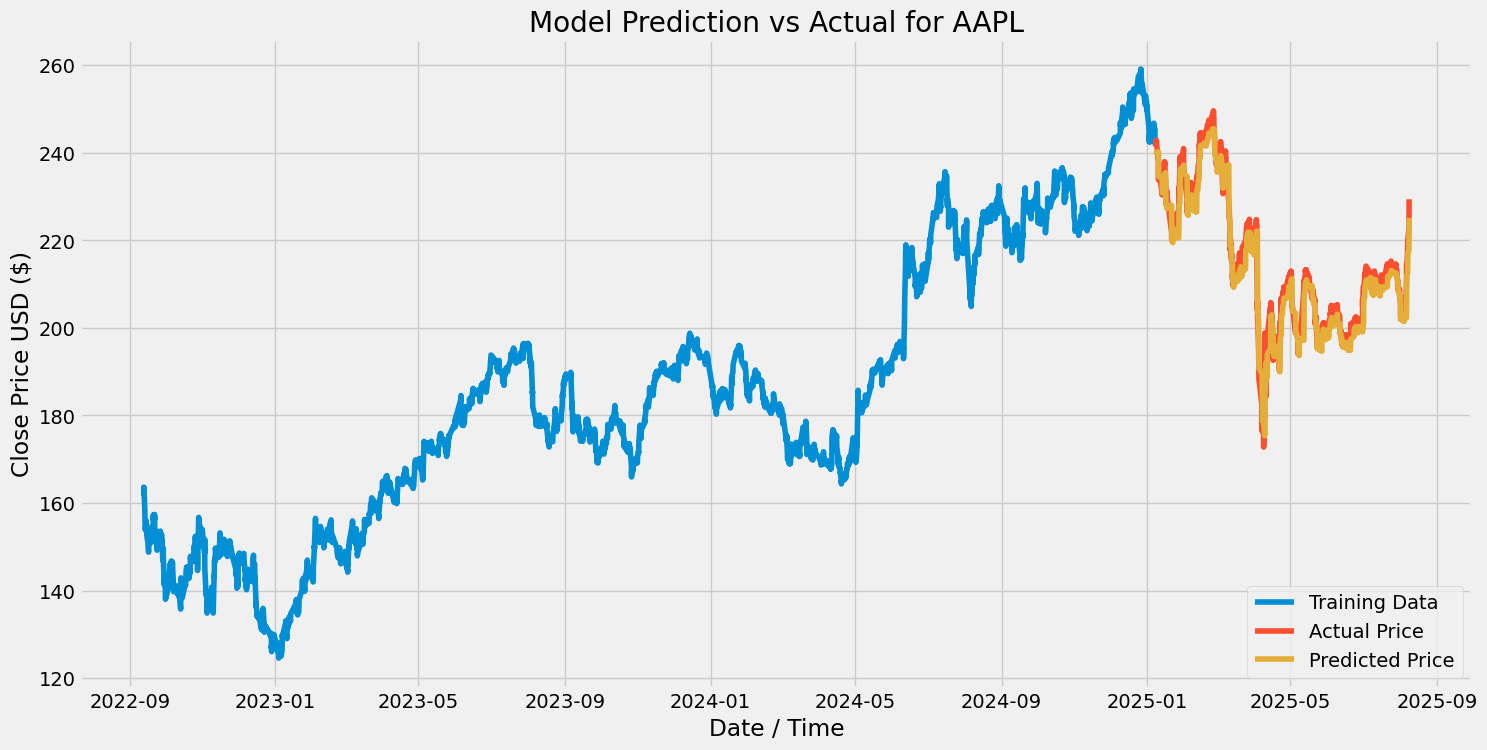


Last 5 Predictions vs Actual Prices:
Price                           Close Predictions
Ticker                           AAPL            
Datetime                                         
2025-08-08 15:30:00+00:00  228.199997  219.085464
2025-08-08 16:30:00+00:00  228.675003  220.546158
2025-08-08 17:30:00+00:00  229.289993  222.200150
2025-08-08 18:30:00+00:00  228.830002  223.817047
2025-08-08 19:30:00+00:00  229.369995  225.125473


In [13]:
# --- Cell 6: Evaluate the Model and Visualize Results ---
from sklearn.metrics import mean_squared_error

print("Making predictions on the test set...")
# Get the model's predicted price values
predictions_scaled = model.predict(x_test)
# Un-scale the predictions back to their original dollar values
predictions = scaler.inverse_transform(predictions_scaled)

# Calculate the Root Mean Squared Error (RMSE)
# This measures the average magnitude of the error in dollars.
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"\nTest Set Root Mean Squared Error (RMSE): ${rmse:.2f}")

# Plot the results for visualization
print("Visualizing the results...")
train = close_data[:training_data_len]
valid = close_data[training_data_len:].copy() # Use .copy() to avoid SettingWithCopyWarning
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title(f'Model Prediction vs Actual for {TICKER}')
plt.xlabel('Date / Time')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price')
plt.legend(loc='lower right')
plt.show()

# Display the last few predicted vs actual values
print("\nLast 5 Predictions vs Actual Prices:")
print(valid[['Close', 'Predictions']].tail())

In [15]:
# --- Cell 7: Predict the Next Hour and Determine Sentiment ---

print("Predicting the price for the next trading hour...")

# Ensure we have enough data for a sequence
if len(close_data) < TIME_STEP:
    raise ValueError(f"Not enough data to form a sequence (need {TIME_STEP}, have {len(close_data)})")

# Get the last TIME_STEP closing prices
last_sequence = close_data['Close'].tail(TIME_STEP).values.reshape(-1, 1)

# Scale using the same scaler
last_sequence_scaled = scaler.transform(last_sequence)

# Reshape for model input
X_pred = np.expand_dims(last_sequence_scaled, axis=0)  # shape: (1, TIME_STEP, 1)

# Predict (scaled)
pred_price_scaled = model.predict(X_pred)

# Convert prediction to float
predicted_price = float(scaler.inverse_transform(pred_price_scaled)[0][0])

# Get the last actual close price as float
last_actual_price = float(close_data['Close'].iloc[-1])

# Determine sentiment
change = predicted_price - last_actual_price
percent_change = (change / last_actual_price) * 100

if predicted_price > last_actual_price:
    sentiment = "Bullish 🐂"
else:
    sentiment = "Bearish 🐻"

# --- Display Final Prediction ---
print("\n" + "=" * 50)
print(f"            FINAL PREDICTION FOR {TICKER}")
print("=" * 50)
print(f"Last Known Close Price:      ${last_actual_price:.2f}")
print(f"Predicted Price (Next Hour): ${predicted_price:.2f}")
print(f"Change:                      ${change:.2f} ({percent_change:+.2f}%)")
print(f"Sentiment:                   {sentiment}")
print("=" * 50)


Predicting the price for the next trading hour...
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

            FINAL PREDICTION FOR AAPL
Last Known Close Price:      $229.37
Predicted Price (Next Hour): $226.14
Change:                      $-3.23 (-1.41%)
Sentiment:                   Bearish 🐻


C:\Users\INDIA\AppData\Local\Temp\ipykernel_19864\1189779029.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_actual_price = float(close_data['Close'].iloc[-1])


In [19]:
# --- FINAL CORRECTED Cell 7: Predict Next Day's OPENING HOUR and Determine Sentiment ---

print("Predicting the price for the NEXT DAY'S FIRST TRADING HOUR using the HOURLY model...")

# Ensure we have enough data
if len(close_data) < TIME_STEP:
    raise ValueError(f"Not enough data to form a sequence (need {TIME_STEP}, have {len(close_data)})")

# Get the last TIME_STEP (60) hours of closing price values
last_sequence = close_data[-TIME_STEP:].values.reshape(-1, 1)

# Scale the sequence
last_sequence_scaled = scaler.transform(last_sequence)

# Reshape for model input
X_pred = np.expand_dims(last_sequence_scaled, axis=0)  # shape: (1, TIME_STEP, 1)

# Predict scaled price
pred_price_scaled = model.predict(X_pred)

# Convert prediction to float
predicted_price = float(scaler.inverse_transform(pred_price_scaled)[0][0])

# Get last actual close price as float
last_actual_price = float(data['Close'].iloc[-1])

# Last actual timestamp
last_actual_timestamp = data.index[-1]

# Calculate change
change = predicted_price - last_actual_price
percent_change = (change / last_actual_price) * 100

# Determine sentiment
if predicted_price > last_actual_price:
    sentiment = "Bullish 🐂"
else:
    sentiment = "Bearish 🐻"

# Next trading day (hardcoded example, can be automated)
next_trading_day_str = "Tuesday, Aug 12, 2025"

# --- Display Final Prediction ---
print("\n" + "="*50)
print(f"      PROXY PREDICTION FOR {TICKER} (using HOURLY model)")
print("="*50)
print(f"Last Known Hourly Close:         ${last_actual_price:.2f} (at {last_actual_timestamp.strftime('%Y-%m-%d %H:%M %Z')})")
print(f"Predicted Price (Next Day Open): ${predicted_price:.2f} (for {next_trading_day_str})")
print(f"Anticipated Change at Open:      ${change:.2f} ({percent_change:+.2f}%)")
print(f"Sentiment for Market Open:       {sentiment}")
print("="*50)
print("\nNOTE: This is a prediction for the start of the next trading day, NOT the final closing price.")


Predicting the price for the NEXT DAY'S FIRST TRADING HOUR using the HOURLY model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

      PROXY PREDICTION FOR AAPL (using HOURLY model)
Last Known Hourly Close:         $229.37 (at 2025-08-08 19:30 UTC)
Predicted Price (Next Day Open): $226.14 (for Tuesday, Aug 12, 2025)
Anticipated Change at Open:      $-3.23 (-1.41%)
Sentiment for Market Open:       Bearish 🐻

NOTE: This is a prediction for the start of the next trading day, NOT the final closing price.


C:\Users\INDIA\AppData\Local\Temp\ipykernel_19864\346390553.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_actual_price = float(data['Close'].iloc[-1])


In [22]:
# --- UPDATED Cell 5: Hyperparameter Tuning with Additional Metrics ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner

# 1. DEFINE THE MODEL-BUILDING FUNCTION
# This function tells Keras Tuner HOW to build the model for each trial.
def build_model(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    hp_units = hp.Int('units', min_value=32, max_value=128, step=16)
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.05)
    
    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    
    # Using the same tuned values for the second layer for simplicity
    model.add(LSTM(units=hp_units, return_sequences=False))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # --- THIS IS THE MODIFIED LINE ---
    # We add 'mean_absolute_error' to the metrics list.
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error',
        metrics=['mean_absolute_error'] # <-- ADDED METRIC
    )
    
    return model

# 2. INSTANTIATE THE TUNER
# The objective for val_loss is still correct as we want to minimize the primary loss function.
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_loss', 
    max_epochs=25,
    factor=3,
    directory='stock_tuning_dir',
    project_name=f'{TICKER}_hourly_tuning_with_mae' # New project name to avoid conflicts
)

# 3. RUN THE SEARCH
print("Starting hyperparameter search... This will take a significant amount of time.")
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# The tuner will automatically use a portion of the training data for validation.
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early], verbose=1)

# 4. RETRIEVE THE BEST HYPERPARAMETERS
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter search complete.
The optimal number of units in the LSTM layers is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout'):.3f}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# 5. BUILD AND TRAIN THE FINAL MODEL
print("\nBuilding the final model with the best hyperparameters...")
model = tuner.hypermodel.build(best_hps)

print("Training the final model on the entire training dataset...")
history = model.fit(
    x_train, 
    y_train, 
    epochs=33,
    validation_split=0.2, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)]
)

# 6. SAVE THE OPTIMIZED MODEL
MODEL_PATH = f"{TICKER}_hourly_lstm_model_tuned.keras"
model.save(MODEL_PATH)
print(f"\nOptimized model training complete. Model saved to: {MODEL_PATH}")
model.summary()

Trial 30 Complete [00h 02m 07s]
val_loss: 0.00046117708552628756

Best val_loss So Far: 0.00012136928125983104
Total elapsed time: 00h 40m 45s

Hyperparameter search complete.
The optimal number of units in the LSTM layers is 64.
The optimal dropout rate is 0.150.
The optimal learning rate for the optimizer is 0.01.


Building the final model with the best hyperparameters...
Training the final model on the entire training dataset...
Epoch 1/33
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - loss: 0.0094 - mean_absolute_error: 0.0518 - val_loss: 9.7512e-04 - val_mean_absolute_error: 0.0270
Epoch 2/33
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 5.9774e-04 - mean_absolute_error: 0.0184 - val_loss: 6.5915e-04 - val_mean_absolute_error: 0.0209
Epoch 3/33
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 4.5054e-04 - mean_absolute_error: 0.0162 - val_loss: 5.3893e-04 - val_mean_absolute_error: 0.0185
Epoch 4/33
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 4.6784e-04 - mean_absol

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,715 (604.36 KB)

 Trainable params: 51,571 (201.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,144 (402.91 KB)

--- Comprehensive Model Evaluation ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Root Mean Squared Error (RMSE):        $2.67
Mean Absolute Error (MAE):           $1.92
Mean Absolute Percentage Error (MAPE): 0.88%
Accuracy (within ±1%):              67.81%
R-squared (R²):                      0.9708
Adjusted R-squared:                  0.9690
Explained Variance Score:            0.9754
Max Error:                           $16.42
----------------------------------------

Visualizing the prediction results...


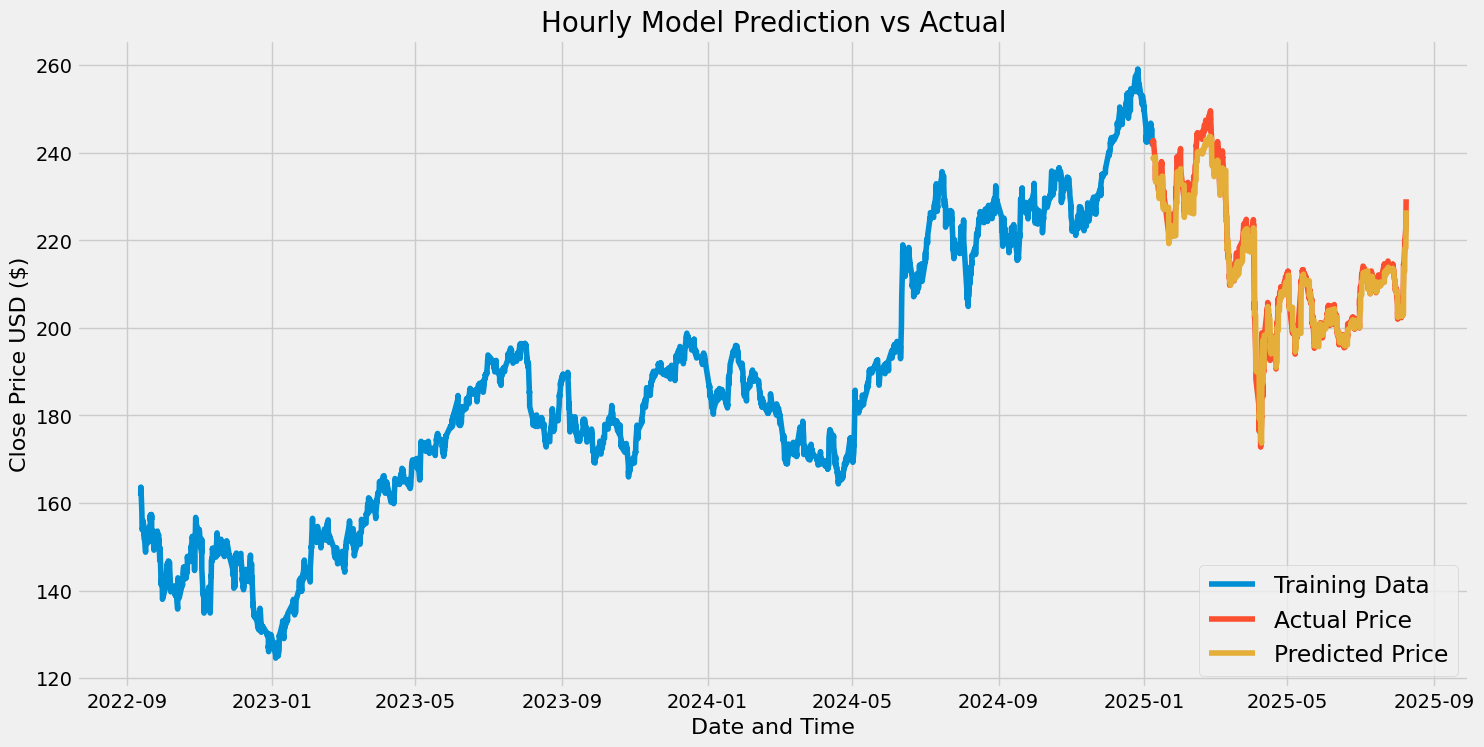

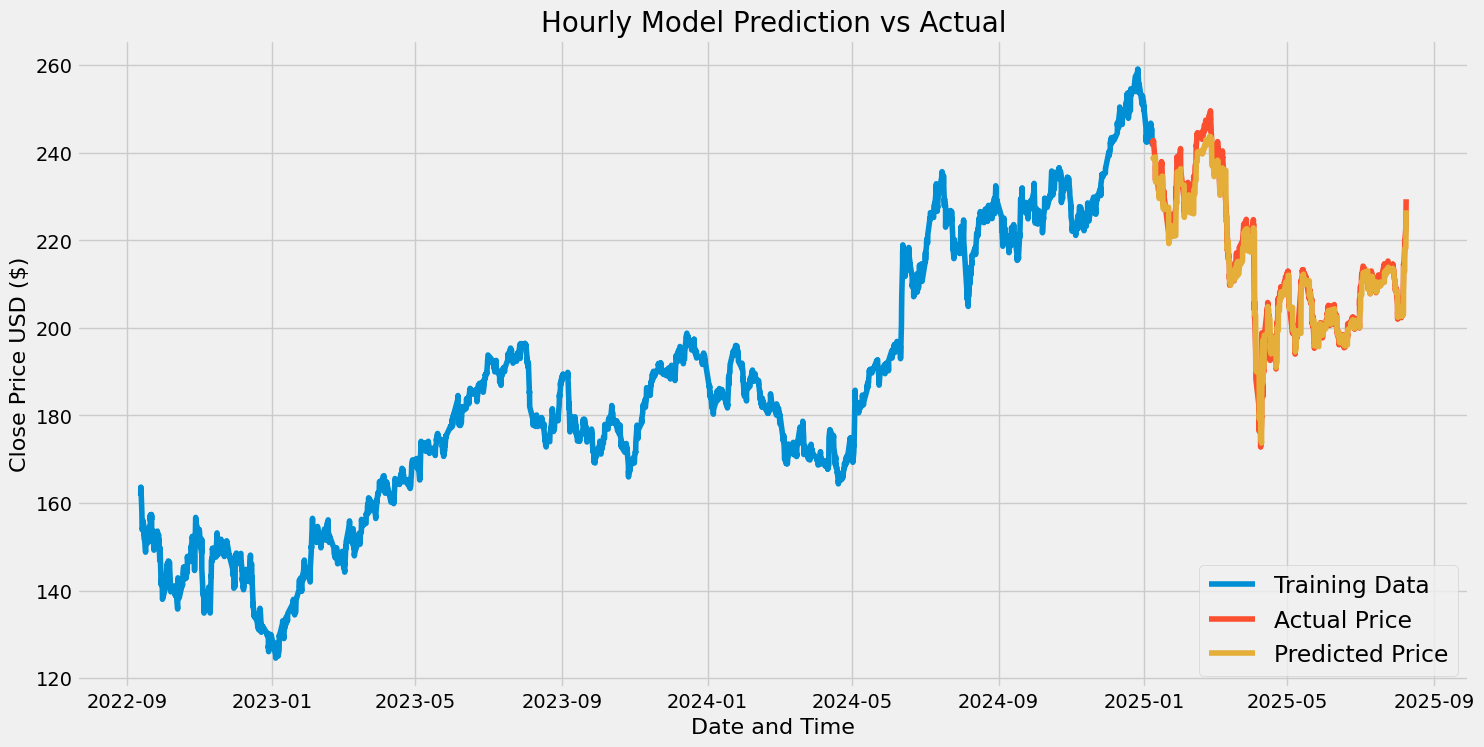

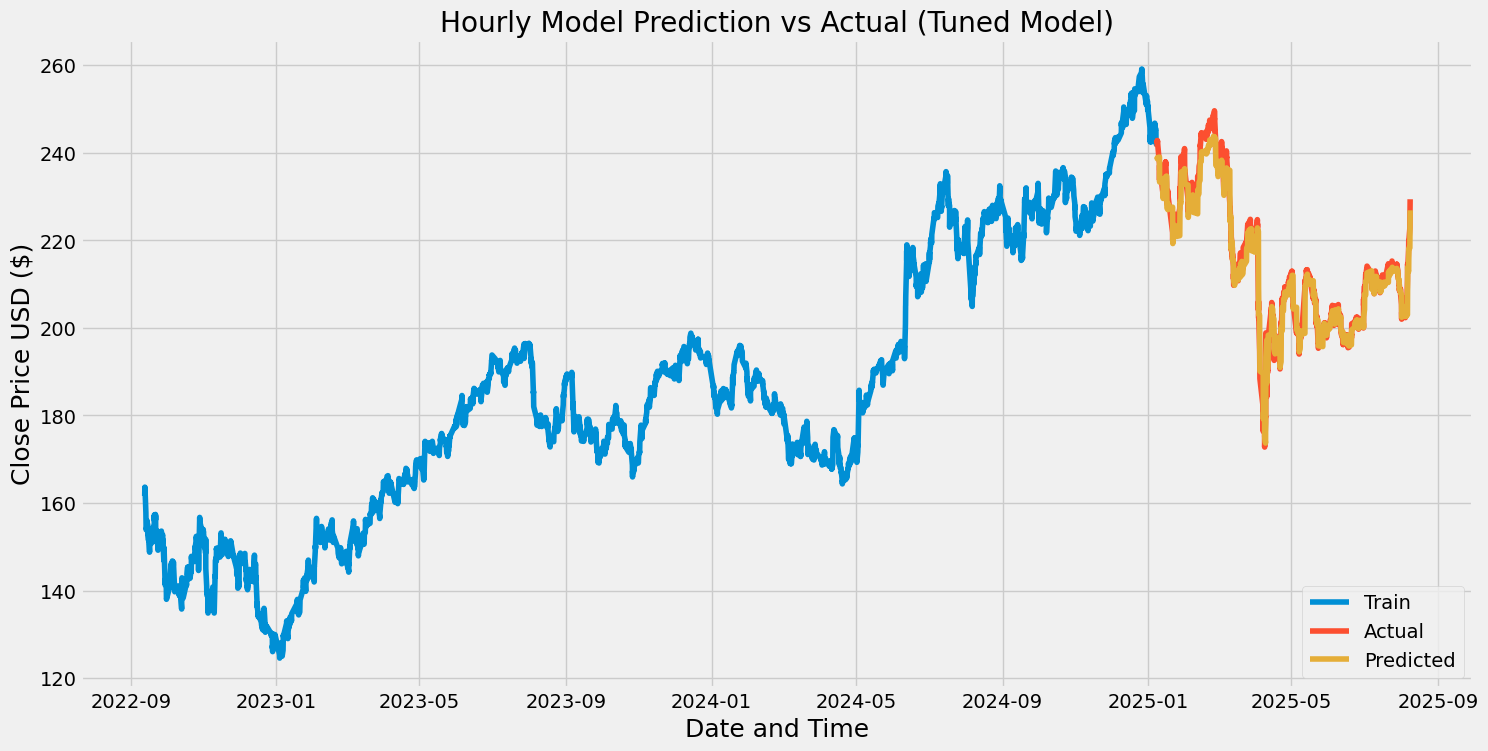


Last 5 Predictions vs Actual Prices:
Price                           Close Predictions
Ticker                           AAPL            
Datetime                                         
2025-08-08 15:30:00+00:00  228.199997  221.033875
2025-08-08 16:30:00+00:00  228.675003  223.436508
2025-08-08 17:30:00+00:00  229.289993  225.324188
2025-08-08 18:30:00+00:00  228.830002  226.503433
2025-08-08 19:30:00+00:00  229.369995  226.849319


In [28]:
# --- Step 6: Evaluate Model with Advanced Metrics and Visualize Results ---

# Import all necessary metrics from scikit-learn
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             r2_score,
                             explained_variance_score,
                             max_error)

print("--- Comprehensive Model Evaluation ---")
# Make predictions on the test set
# This uses the 'model' and 'x_test' variables from the previous cells
predictions = model.predict(x_test)
# Un-scale the predictions back to their original dollar values
predictions = scaler.inverse_transform(predictions)

# --- CALCULATE AND DISPLAY PERFORMANCE METRICS ---

# 1. Root Mean Squared Error (RMSE)
# Measures the standard deviation of the prediction errors. Sensitive to large errors.
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE):        ${rmse:.2f}')

# 2. Mean Absolute Error (MAE)
# The average absolute error in dollars. Very interpretable.
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE):           ${mae:.2f}')

# 3. Mean Absolute Percentage Error (MAPE)
# The average prediction error in percentage terms.
epsilon = 1e-10
mape = mean_absolute_percentage_error(y_test + epsilon, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')

# 4. Custom Prediction Accuracy (%)
# The percentage of predictions that fall within a ±1% tolerance of the actual price.
tolerance = 0.01
accurate_predictions = np.abs((predictions - y_test) / (y_test + epsilon)) <= tolerance
accuracy_within_tolerance = np.mean(accurate_predictions) * 100
print(f'Accuracy (within ±{tolerance:.0%}):              {accuracy_within_tolerance:.2f}%')

# 5. R-squared (R²)
# Proportion of the variance in the actual prices that is predictable from the model.
r2 = r2_score(y_test, predictions)
print(f'R-squared (R²):                      {r2:.4f}')

# 6. Adjusted R-squared
# R-squared adjusted for the number of predictors (our time steps).
n = len(y_test)
p = x_test.shape[1] # This is equal to TIME_STEP
if (n - p - 1) == 0:
    adj_r2 = np.nan
else:
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared:                  {adj_r2:.4f}')

# 7. Explained Variance Score
# Measures how well the model accounts for the dataset's variation. 1.0 is perfect.
explained_variance = explained_variance_score(y_test, predictions)
print(f'Explained Variance Score:            {explained_variance:.4f}')

# 8. Max Error
# The single worst prediction error (in dollars) in the test set.
max_err = max_error(y_test, predictions)
print(f'Max Error:                           ${max_err:.2f}')

print("-" * 40)

# --- VISUALIZE THE RESULTS ---
print("\nVisualizing the prediction results...")

# Prepare data for plotting using variables from earlier cells
train = close_data[:training_data_len]
valid = close_data[training_data_len:].copy() # Use .copy() to avoid SettingWithCopyWarning
valid['Predictions'] = predictions

# Create the plot
plt.figure(figsize=(16, 8))
plt.title('Hourly Model Prediction vs Actual (Tuned Model)')
plt.xlabel('Date and Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price')
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

# Display the last few predicted vs actual values for a direct comparison
print("\nLast 5 Predictions vs Actual Prices:")
print(valid[['Close', 'Predictions']].tail())

--- Model Evaluation ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step
Root Mean Squared Error (RMSE): $2.67
Mean Absolute Error (MAE):      $1.92
Mean Absolute Percentage Error (MAPE): 0.88%
R-squared (R²): 97.08%
--------------------------

Visualizing the prediction results...


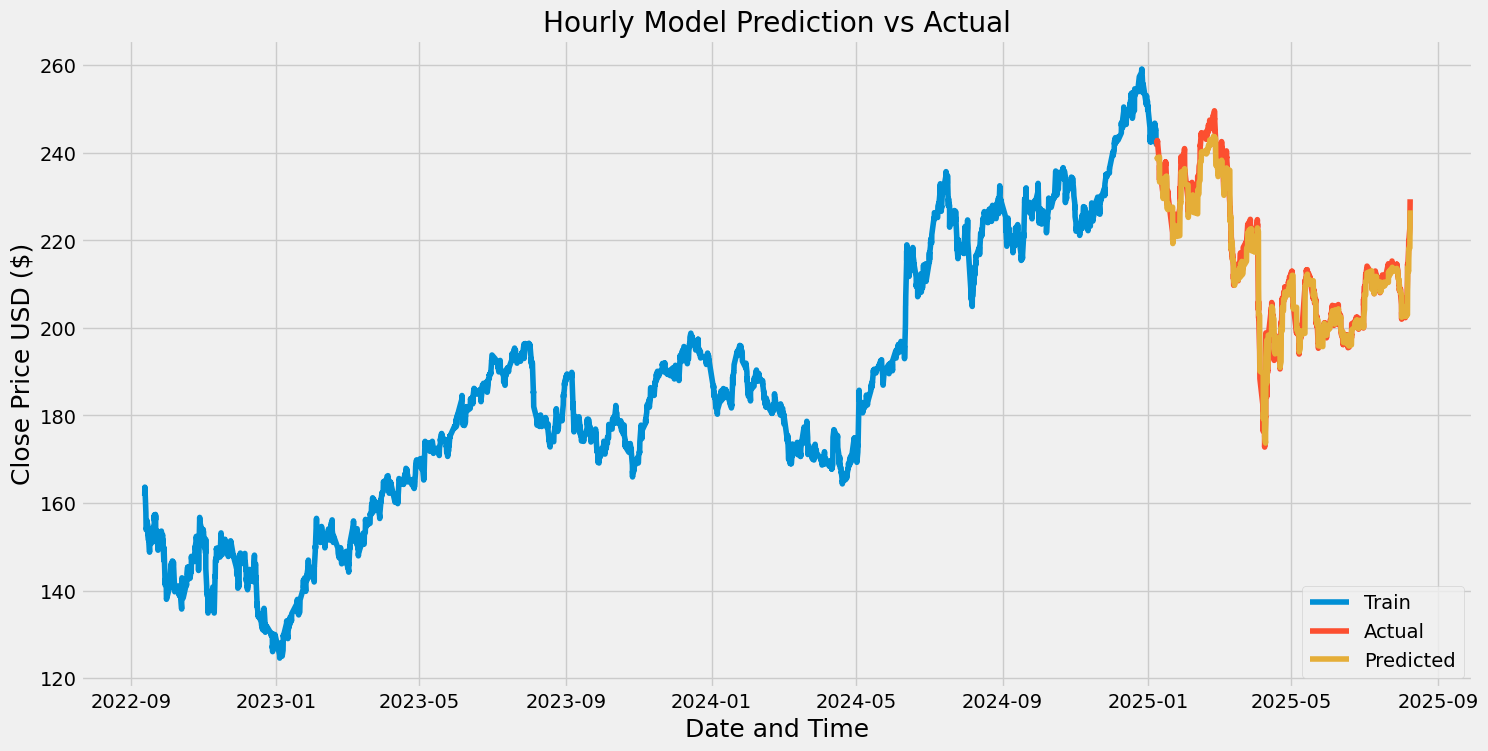


Last 5 Predictions vs Actual Prices:
Price                           Close Predictions
Ticker                           AAPL            
Datetime                                         
2025-08-08 15:30:00+00:00  228.199997  221.033875
2025-08-08 16:30:00+00:00  228.675003  223.436508
2025-08-08 17:30:00+00:00  229.289993  225.324188
2025-08-08 18:30:00+00:00  228.830002  226.503433
2025-08-08 19:30:00+00:00  229.369995  226.849319


In [23]:
# --- Step 6: Evaluate and Visualize with Additional Metrics ---

# Import additional metrics from scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

print("--- Model Evaluation ---")
# Make predictions on the test set
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # Un-scale predictions to dollar values

# --- CALCULATE AND DISPLAY PERFORMANCE METRICS ---

# 1. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): ${rmse:.2f}')

# 2. Mean Absolute Error (MAE) - NEW
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE):      ${mae:.2f}')

# 3. Mean Absolute Percentage Error (MAPE) - NEW
# We add a small epsilon to y_test to avoid division by zero if any price is 0
epsilon = 1e-10 
mape = mean_absolute_percentage_error(y_test + epsilon, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2%}')

# 4. R-squared (R²) - NEW
r2 = r2_score(y_test, predictions)
print(f'R-squared (R²): {r2:.2%}')
print("-" * 26)


# --- VISUALIZE THE RESULTS ---
print("\nVisualizing the prediction results...")

# Prepare data for plotting
train = close_data[:training_data_len]
valid = close_data[training_data_len:].copy() # Use .copy() to avoid SettingWithCopyWarning
valid['Predictions'] = predictions

# Create the plot
plt.figure(figsize=(16,8))
plt.title('Hourly Model Prediction vs Actual')
plt.xlabel('Date and Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], label='Training Data')
plt.plot(valid['Close'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price')
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()

# Display the last few predicted vs actual values
print("\nLast 5 Predictions vs Actual Prices:")
print(valid[['Close', 'Predictions']].tail())

In [27]:
# --- Step 6: Evaluate and Visualize with Advanced Metrics ---
import streamlit as st
# Import all necessary metrics from scikit-learn
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error, 
                             mean_absolute_percentage_error, 
                             r2_score,
                             explained_variance_score,
                             max_error)

print("--- Comprehensive Model Evaluation ---")
# Make predictions on the test set
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # Un-scale predictions to dollar values

# --- CALCULATE AND DISPLAY ADVANCED PERFORMANCE METRICS ---

# --- Primary Error Metrics ---
st.write("### Primary Error Metrics")
col1, col2 = st.columns(2)
# 1. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
col1.metric("Root Mean Squared Error (RMSE)", f"${rmse:.2f}", help="The square root of the average of squared differences between prediction and actual value. More sensitive to large errors.")

# 2. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
col2.metric("Mean Absolute Error (MAE)", f"${mae:.2f}", help="The average absolute difference between prediction and actual value. Easily interpretable.")

# --- Percentage and Relative Metrics ---
st.write("### Relative & Percentage-Based Metrics")
col3, col4 = st.columns(2)
# 3. Mean Absolute Percentage Error (MAPE)
epsilon = 1e-10 
mape = mean_absolute_percentage_error(y_test + epsilon, predictions)
col3.metric("Mean Absolute Percentage Error (MAPE)", f"{mape:.2%}", help="The average of the absolute percentage differences between prediction and actual value.")

# 4. Custom Prediction Accuracy (%) - NEW
tolerance = 0.01  # Define tolerance, e.g., 0.01 for ±1%
accurate_predictions = np.abs((predictions - y_test) / (y_test + epsilon)) <= tolerance
accuracy_within_tolerance = np.mean(accurate_predictions) * 100
col4.metric(f"Accuracy (within ±{tolerance:.0%})", f"{accuracy_within_tolerance:.2f}%", help=f"Percentage of predictions that fall within a {tolerance:.0%} range of the actual price.")


# --- Goodness of Fit Metrics ---
st.write("### Goodness of Fit Metrics")
col5, col6 = st.columns(2)
# 5. R-squared (R²)
r2 = r2_score(y_test, predictions)
col5.metric("R-squared (R²)", f"{r2:.4f}", help="Proportion of the variance in the dependent variable that is predictable. 1 is a perfect fit.")

# 6. Adjusted R-squared - NEW
n = len(y_test)  # Number of samples
p = x_test.shape[1]  # Number of predictors (our TIME_STEP)
if (n - p - 1) == 0:
    adj_r2 = np.nan # Avoid division by zero
else:
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
col6.metric("Adjusted R-squared", f"{adj_r2:.4f}", help="R-squared adjusted for the number of predictors in the model. Often considered more accurate.")

# --- Additional Diagnostic Metrics ---
st.write("### Additional Diagnostics")
col7, col8 = st.columns(2)
# 7. Explained Variance Score - NEW
explained_variance = explained_variance_score(y_test, predictions)
col7.metric("Explained Variance Score", f"{explained_variance:.4f}", help="Measures how well the model can account for the variation of the dataset. 1 is perfect.")

# 8. Max Error - NEW
max_err = max_error(y_test, predictions)
col8.metric("Max Error", f"${max_err:.2f}", help="The single largest error found in the test set, indicating the worst-case prediction.")


# --- VISUALIZE THE RESULTS ---
st.write("### Prediction vs. Actual Price Chart")
# Prepare data for plotting
train = close_data[:training_data_len]
valid = close_data[training_data_len:].copy() 
valid['Predictions'] = predictions

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Hourly Model Prediction vs Actual', fontsize=20)
ax.set_xlabel('Date and Time', fontsize=16)
ax.set_ylabel('Close Price USD ($)', fontsize=16)
ax.plot(train['Close'], label='Training Data')
ax.plot(valid['Close'], label='Actual Price')
ax.plot(valid['Predictions'], label='Predicted Price')
ax.legend(loc='lower right', fontsize='large')
st.pyplot(fig)


# Display the last few predicted vs actual values
st.write("#### Last 5 Predictions vs Actual Prices:")
st.dataframe(valid[['Close', 'Predictions']].tail())

--- Comprehensive Model Evaluation ---
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


2025-08-11 19:52:12.909 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 19:52:12.911 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 19:52:12.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 19:52:12.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 19:52:12.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 19:52:12.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 19:52:12.921 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-11 19:52:12.924 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()